In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
from scipy.special import gamma

plt.style.use(["science","bright","grid"])

V_WRITES    = [0.01125, 0.025, 0.04875]
T_WRITES    = [2.23, 1.09, 0.36]
T_WAITS     = [0.1,  0.15,  0.2,  0.3,  0.5,  0.7,  1. ,  1.5 ,  2. ,  3. ,  5. ,  7. , 10. , 15.  , 20. , 30. , 50. , 70. , 100. ]
N_VOLT      = 50000
TIME_STEP   = 1e-11
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/two_steps/"
N_PARTICLES = 9

def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
topo    = {"Nx" : N_PARTICLES, "Ny" : N_PARTICLES, "e_pos": [
               [(N_PARTICLES-1)//2, 0], [0, 0], [N_PARTICLES-1, 0],
               [0, (N_PARTICLES-1)//2], [N_PARTICLES-1, (N_PARTICLES-1)//2],
               [0, N_PARTICLES-1], [N_PARTICLES-1, N_PARTICLES-1], [(N_PARTICLES-1)//2, N_PARTICLES-1]], "electrode_type" : ['constant']*8}
sim_c   = Simulation(topo)
i               = 40
j               = 41
tau_t_center    = (25*1e6*1e-9)/(sim_c.get_inv_capacitance_matrix()[i][i]+sim_c.get_inv_capacitance_matrix()[j][j]-2*sim_c.get_inv_capacitance_matrix()[i][j]) # in ns
print(tau_t_center)

i               = 76
tau_t_output    = (25*1e6*1e-9)/(sim_c.get_inv_capacitance_matrix()[i][i]) # in ns
print(tau_t_output)

0.6638073988052922
0.9913285501264587


In [5]:
t   = np.arange(N_VOLT) * TIME_STEP
y   = {V : {t : [pd.read_csv(f"{FOLDER}Nx=9_Ny=9_Ne=8_{V:.5f}_{t:.5f}_{tw:.5f}.csv")['Observable'].values for tw in T_WAITS] for t in T_WRITES} for V in V_WRITES}
# y_e = np.array([pd.read_csv(f"{FOLDER}Nx=3_Ny=3_Ne=8_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T

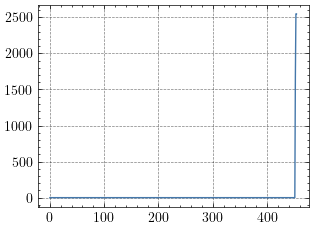

In [10]:
plt.plot(y[0.01125][2.23][0])

[2.05609570054222, 2.2393920268678835, 1.433212122226331, 2.0001292447432926, 1.2894359315801514, 1.6648637866367633, 1.2245367753770136, 1.0924192161612496, 0.9812837024521279, 1.103632927427579, 0.8487961068151594, 0.7028366919475882, 1.0997325010971701, 0.9657896539973593, 0.5916055836973033, 0.6511541633974469, 0.7242012321741124, 0.6230616324511067, 0.7055587456524505, 0.7705966561499396, 0.4270113179189445, 0.5211904158513931, 0.5270782977846156, 0.4591952516300195, 0.3575820803249119, 0.43302271007859605, 0.3464545415548897, 0.36703612599823127, 0.3787758014882375, 0.37830147723696733, 0.45497703884198226, 0.3620624752319773]
[0.6277411782168981, 0.7257795518509725, 0.6744723212498862, 0.6872616348950624, 0.653174156507357, 0.7484309500408277, 0.6836098593555919, 0.6838726612588427, 0.6768343979634978, 0.7092146087088322, 0.7373576402441588, 0.6676310939702237, 0.8304702988133156, 0.7750855467208438, 0.6595226722716893, 0.7163942175058472, 0.7428453518284078, 0.8150075596912751,

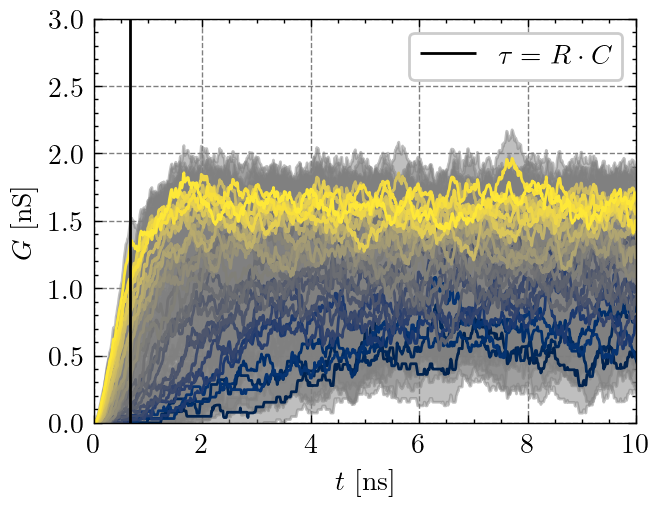

In [7]:
skip    = 0
min_con = 10
sat     = 1000
p_sat   = 0.95
fit_val = []
taus    = []
cvs     = []
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(U0_LIST[skip:]):

    # Plot Data
    t_copy  = t.copy()*1e9
    y_copy  = (y[:,i+skip].copy()*1e-9)/V
    ye_copy = (y_e[:,i+skip].copy()*1e-9)/V

    ax.plot(t_copy, y_copy, '-', color=CMAP(PLOT_NORM(V)))
    ax.fill_between(t_copy, y_copy-ye_copy, y_copy+ye_copy, color='grey', alpha=0.5)

    # Get Saturation Values and Transient Part
    sat_mean    = np.median(y_copy[-sat:])

    # threshold crossing: first index where y >= p_sat*sat_mean and persists for min_consec samples
    thresh  = p_sat * sat_mean
    above   = y_copy >= thresh
    # find first run of at least min_consec True
    idx_cut = None
    consec = 0
    for i, val in enumerate(above):
        if val:
            consec += 1
            if consec >= min_con:
                idx_cut = i - (min_con - 1) + 1
                break
        else:
            consec = 0

    # idx_cut     = int(np.where(y_copy>=(p_sat*sat_mean))[0][0])
    t_plot      = t_copy[:idx_cut]
    y_plot      = y_copy[:idx_cut]

    # Get Tau and CV (model-free)
    f       = (sat_mean - y_plot) / sat_mean
    norm    = np.trapz(f, x=t_plot)
    tau     = np.trapz(t_plot * f, x=t_plot) / norm
    tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm
    sigma   = np.sqrt(tau2 - tau**2)
    cv      = sigma / tau

    # Append
    taus.append(tau)
    cvs.append(cv)

_ = ax.vlines(tau_t_center, 0, 3, colors='black', label='$\\tau = R \cdot C$')
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G$ [nS]")
_ = ax.set_xlim(0, 1000*TIME_STEP*1e9)
_ = ax.set_ylim(0, 3)
_ = ax.legend()
print(taus)
print(cvs)

In [13]:
np.logspace(-1.0, 2.0, 32)*1e-9

array([1.00000000e-10, 1.24960914e-10, 1.56152301e-10, 1.95129342e-10,
       2.43835410e-10, 3.04698957e-10, 3.80754602e-10, 4.75794431e-10,
       5.94557071e-10, 7.42963951e-10, 9.28414545e-10, 1.16015530e-09,
       1.44974067e-09, 1.81160919e-09, 2.26380341e-09, 2.82886943e-09,
       3.53498111e-09, 4.41734470e-09, 5.51995432e-09, 6.89778538e-09,
       8.61953566e-09, 1.07710506e-08, 1.34596032e-08, 1.68192432e-08,
       2.10174801e-08, 2.62636353e-08, 3.28192787e-08, 4.10112707e-08,
       5.12480588e-08, 6.40400427e-08, 8.00250228e-08, 1.00000000e-07])

In [22]:
np.round(np.logspace(-1.0, 2.0, CPU_CNT),4)*1e-9

array([1.00000e-10, 1.25000e-10, 1.56200e-10, 1.95100e-10, 2.43800e-10,
       3.04700e-10, 3.80800e-10, 4.75800e-10, 5.94600e-10, 7.43000e-10,
       9.28400e-10, 1.16020e-09, 1.44970e-09, 1.81160e-09, 2.26380e-09,
       2.82890e-09, 3.53500e-09, 4.41730e-09, 5.52000e-09, 6.89780e-09,
       8.61950e-09, 1.07711e-08, 1.34596e-08, 1.68192e-08, 2.10175e-08,
       2.62636e-08, 3.28193e-08, 4.10113e-08, 5.12481e-08, 6.40400e-08,
       8.00250e-08, 1.00000e-07])

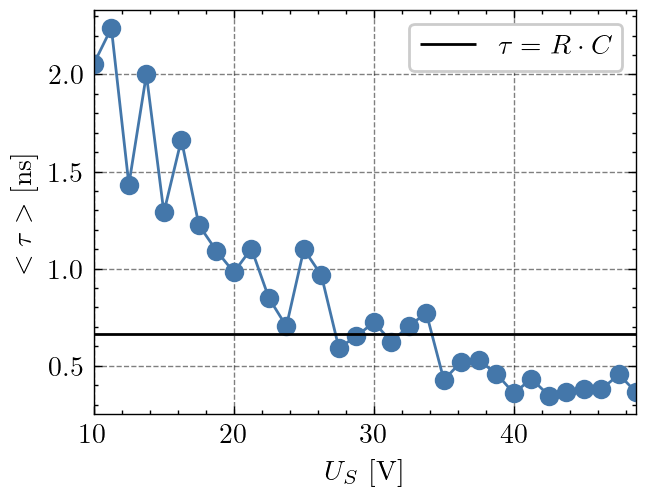

In [8]:
fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(U0_LIST[skip:])*1000, taus, '-o')#, label='$<\\tau> = \\frac{\\tau_K}{\\beta}\\Gamma(\\frac{1}{\\beta})$')
_ = ax.hlines(tau_t_center, U0_LIST[skip]*1000, U0_LIST[-1]*1000, colors='black', label='$\\tau = R \cdot C$')
_ = ax.legend()
_ = ax.set_xlabel("$U_S$ [V]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(U0_LIST[skip]*1000, U0_LIST[-1]*1000)

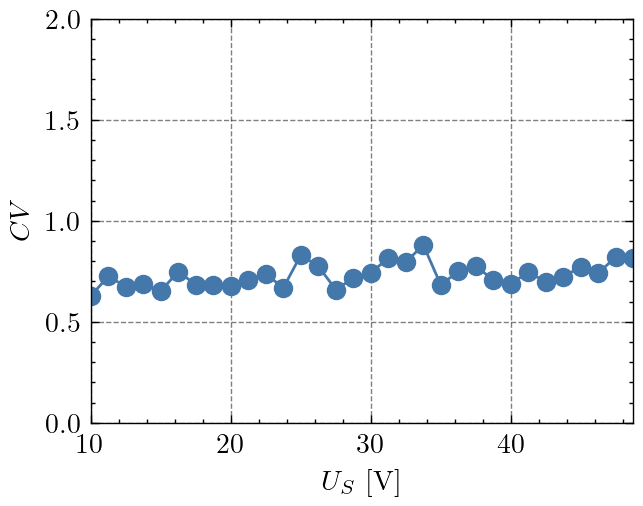

In [45]:
fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(U0_LIST[skip:])*1000, cvs, '-o')
_ = ax.set_xlabel("$U_S$ [V]")
_ = ax.set_ylabel("$CV$")
_ = ax.set_ylim(0,2)
_ = ax.set_xlim(U0_LIST[skip]*1000, U0_LIST[-1]*1000)